# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

----

# Read `Info.txt` file

This file has labeled image names

In [2]:
# Read the text file with space(' ') as the delimitter
df = pd.read_csv('Info.txt', sep = ' ')

In [3]:
df.head()

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,Unnamed: 7
0,mdb001,G,CIRC,B,535.0,425.0,197.0,NaN
1,mdb002,G,CIRC,B,522.0,280.0,69.0,NaN
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0,NaN


-----

# Clean the DataFrame

In [4]:
# Select useful('IMAGE' and 'SEVERITY') columns
df['IMAGE'] = df['REFNUM']
df = df[['IMAGE', 'SEVERITY']]

In [5]:
# Fill NA values i.e. images having no growth with 'N'(Normal)
df['SEVERITY'].fillna('N', inplace = True)

In [6]:
# Drop duplicates if any
df.drop_duplicates(subset = 'IMAGE', inplace = True)

In [7]:
# Reset the index
df.set_index(np.arange(len(df)), inplace = True)

In [8]:
df.head()

,IMAGE,SEVERITY
0,mdb001,B
1,mdb002,B
2,mdb003,N
3,mdb004,N
4,mdb005,B


-----

# Analyse the DataFrame

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   IMAGE     323 non-null    object
 1   SEVERITY  323 non-null    object
dtypes: object(2)
memory usage: 7.6+ KB


#### Classes of Severity

- Benign: Non cancerous
- Malignant: Cancerous
- No growth

In [10]:
classes = df.groupby('SEVERITY').count()

# Change the index
index = pd.Series(classes.index)
index = index.map({'B': 'Benign growth', 'M': 'Malignant growth', 'N': 'No growth'})

# Reassign the index
classes.index = index.values

# Reassign the column
col = list(classes.columns)
col[0] = 'Number of images'
classes.columns = col

classes

,Number of images
Benign growth,64
Malignant growth,52
No growth,207



---
# Save the DataFrame

In [11]:
# Do not save the index
df.to_csv('newInfo.txt', sep = ' ', index = False)

---

# Change the image format

- Raw image format is `.pgm` which takes a lot of space
- Convert it to `.jpg` which takes a lot less space


In [12]:
# Directory with raw .pgm images
img_dir = 'all-mias'

# Image names with extension
img_name = np.array(os.listdir(img_dir))

# Final image address
img_add = np.char.add(img_dir + '/', img_name)

# Directory which will have .jpg images
outDir = 'all-mias-jpg'

In [13]:
# Function to convert .pgm image to .jpg image
def PNG_to_JPG(img, img_add, outDir):
    new_file = f'{img}.jpg'
    with Image.open(img_add) as im:
        im.save(outDir + '/' + new_file)

In [14]:
total_images = len(img_name)

# Iterate over all images
for i in range(total_images):
    # Image name
    img = img_name[i]
    
    # Image name without extension
    img_no_extension = img[:len(img) - 4]
    PNG_to_JPG(img_no_extension, img_add[i], outDir)

#### Folder size comparison

In [15]:
# Function to compute size of the folder
def folderSize(folder):
    size = 0
    for file in os.scandir(folder):
        size += os.stat(file).st_size
        
    return np.round(size / 1e6, 2)

In [16]:
print(f'Size of images in .pgm format: {folderSize(img_dir)} MB')
print(f'Size of images in .jpg format: {folderSize(outDir)} MB')

Size of images in .pgm format: 337.65 MB
Size of images in .jpg format: 12.1 MB


In [17]:
# Change the image address to the new folder
img_name = np.array(os.listdir(outDir))
img_add = np.char.add(outDir + '/', img_name)

----

# Function to plot images

In [ ]:
# Function to plot the image, remove the axes and give a title
# This will be called throughout the code
def plot(axes, title, img_to_plot):
    axes.axis('off')
    axes.imshow(img_to_plot, cmap = 'gray')
    axes.set_title(title)

----

# Load and display a random image

- Generate a random number
- Load an image in grayscale
- Display the image

In [18]:
# Generate a random number
rand = np.random.randint(0, total_images)
rand

158

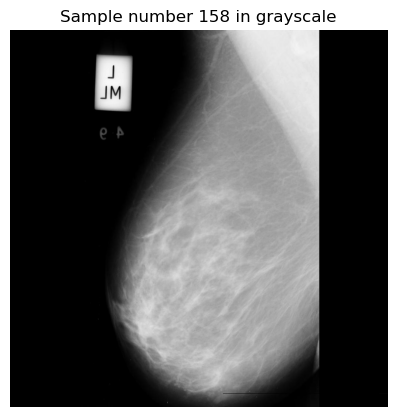

In [38]:
# Read a random image in grayscale
img = cv2.imread(img_add[rand], cv2.IMREAD_GRAYSCALE)

# Print the raw image in the notebook with gray as the colormap
fig, axes = plt.subplots(figsize = (10, 5), dpi = 100)
plot(axes, f'Sample number {rand} in grayscale', img)

-------

# Crop the image

Crop the image to focus on the breast

In [20]:
rows, cols = img.shape
img.shape

(1024, 1024)

(1004, 994)

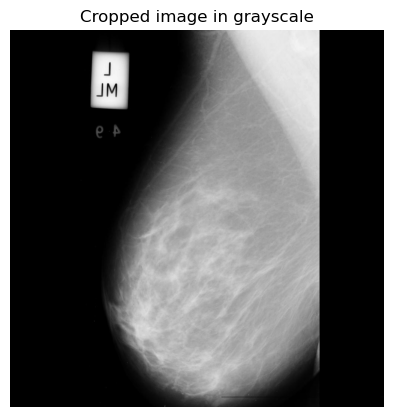

In [40]:
# Crop the image using experimental values
img = img[10:rows - 10, 15:cols - 15]

# Display the image
fig, axes = plt.subplots(figsize = (10, 5), dpi = 100)
plot(axes, 'Cropped image in grayscale', img)

img.shape

-----

# Remove labels

Labels consist of all the extra things in an image

#### Method
1. Apply `binary threshold` function to highlight prominent areas
2. Extract the part with maximum area using `contours`. We will call it a mask
3. Do a `bitwise AND` on the original image using the mask to remove labels from the grayscale image

This is done to increase the accuracy of the model

Refer to: https://learnopencv.com/contour-detection-using-opencv-python-c/ for more details

### 1. Apply binary threshold function

- Popular segmentation technique
- Input image must be in grayscale
- This converts the image to black and white, highlighting the objects of interest with same intensity
- The contour algorithm can now detect the borders of the objects from these white pixels

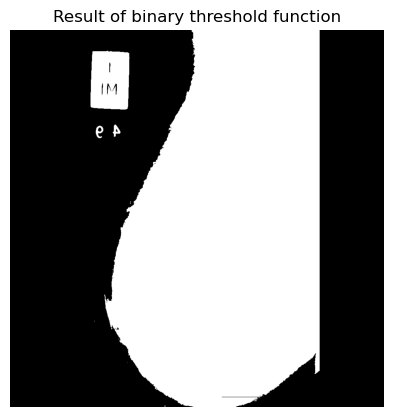

In [41]:
# Apply binary threshold function
# Source image, threshold value, max value assigned to pixels which cross the threshold, type of thresholding
# Pixel values lie between 0 to 255
# Thresh = 30 is an experimental value
threshold, outputImg = cv2.threshold(src = img, thresh = 30, maxval = 255, type = cv2.THRESH_BINARY)

# Display the image
fig, axes = plt.subplots(figsize = (10, 5), dpi = 100)
plot(axes, 'Result of binary threshold function', outputImg)

### 2. Find the part with maximum area using contours

1. Get all contours
2. Find the contour with maximum area

Refer to: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18

In [60]:
# Get all contours
# Mode refers to the type of contours that will be retrieved, cv2.RETR_EXTERNAL retrives only the extreme outer contours
# Method refers to method in which we want to store the contours, cv2.CHAIN_APPROX_SIMPLE will compress segments
contours, hierarchy = cv2.findContours(outputImg, mode = cv2.RETR_EXTERNAL, method = cv2.CHAIN_APPROX_SIMPLE)

# Display number of contours
print("Number of contours found:", len(contours))

Number of contours found: 19


In [61]:
# Find the contour with maximum area
maxContour = 0 
maxContourData = -1

for contour in range(len(contours)):
    # Calculate and compare area
    contourSize = cv2.contourArea(contours[contour])
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour

In [62]:
# Generate 2 black images
mask = np.zeros_like(outputImg)
ctr = mask.copy()

# Draw the mask
cv2.drawContours(mask, contours, maxContourData, color = (255, 255, 255), thickness = -1)
# Draw the contour
cv2.drawContours(ctr, contours, maxContourData, color = (255, 255, 255), thickness = 5);

### 3. Bitwise AND to remove labels

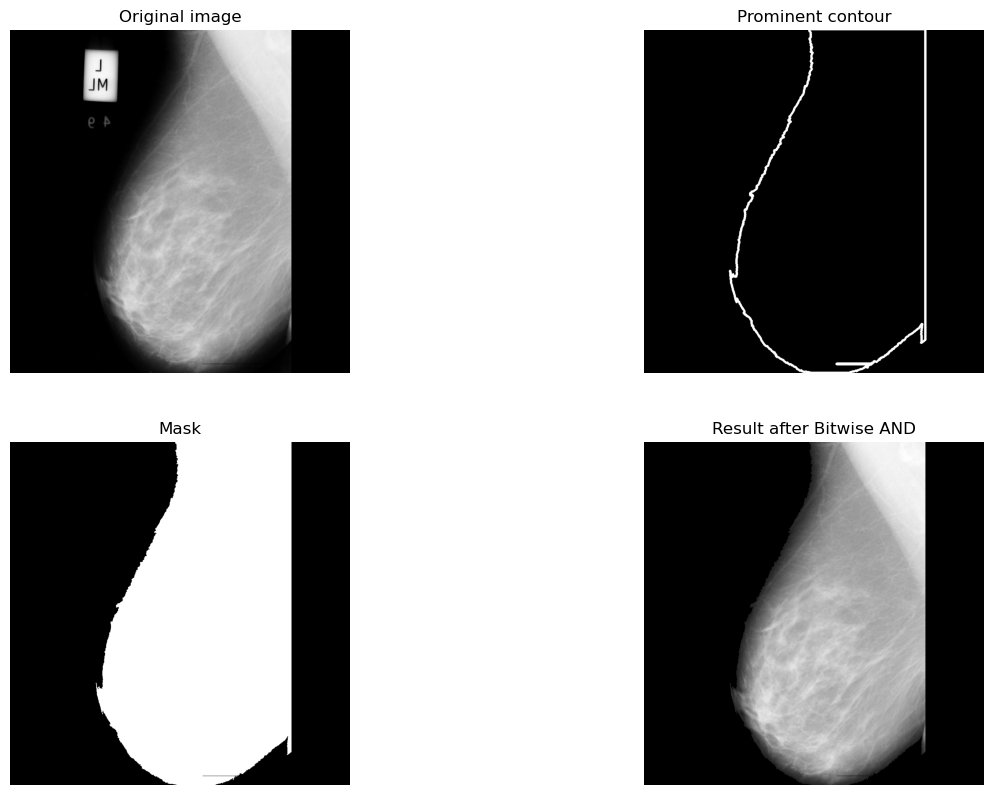

In [63]:
# Display the images
fig, axes = plt.subplots(2, 2, figsize = (15, 10), dpi = 100)

titles = [['Original image', 'Prominent contour'], ['Mask', 'Result after Bitwise AND']]
# Bitwise AND taken using the mask here
imgs = [[img, ctr], [mask, cv2.bitwise_and(src1 = img, src2 = img, mask = mask)]]

for i in range(len(titles)):
    for j in range(len(titles[i])):
        plot(axes[i][j], titles[i][j], imgs[i][j])

# Apply methods to blur the boundaries

1. Gaussian blur
2. Median blur

Refer to: https://www.pyimagesearch.com/2021/04/28/opencv-smoothing-and-blurring/

This is done to increase the accuracy of the model

### 1. Gaussian blur

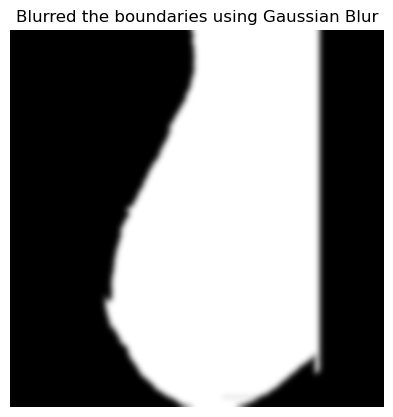

In [64]:
mask = cv2.GaussianBlur(mask, (49, 49), 0)

fig, axes = plt.subplots(figsize = (10, 5), dpi = 100)
plot(axes, 'Blurred the boundaries using Gaussian Blur', mask)

### 2. Median blur

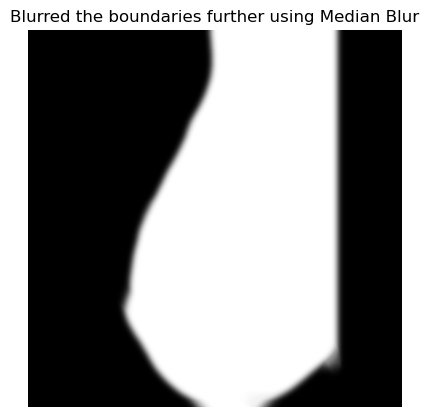

In [65]:
mask = cv2.medianBlur(mask, 49)

fig, axes = plt.subplots(figsize = (10, 5), dpi = 100)
plot(axes, 'Blurred the boundaries further using Median Blur', mask)

# Take bitwise AND

In [66]:
finalImg = cv2.bitwise_and(img, img, mask = mask)

# Display results

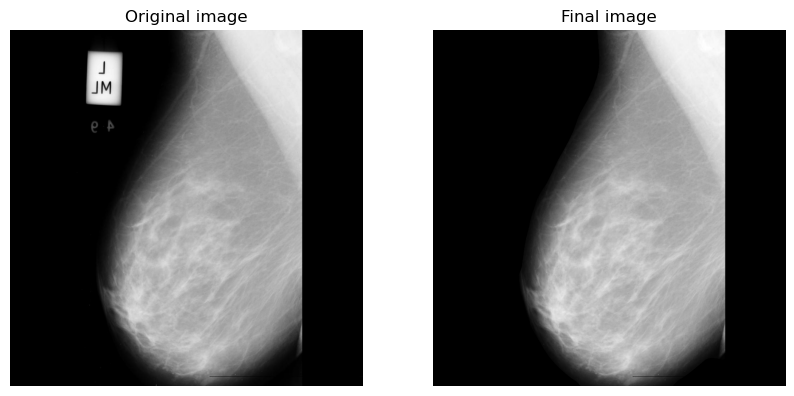

In [67]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5), dpi = 100)

titles = ['Original image', 'Final image']
imgs = [img, finalImg]

for i in range(len(titles)):
    plot(axes[i], titles[i], imgs[i])

In [70]:
len(img_name)

322